# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build Dataset

- **Block_size**: Number of characters used to predict next character
- **Xtr, Xdev, Xte** : Training, dev/validation, and testing set

In [4]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     
Xdev, Ydev = build_dataset(words[n1:n2])   
Xte,  Yte  = build_dataset(words[n2:])     


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.randn((1, n_hidden)) #Scaling effect on batch norm
bnbias = torch.randn((1, n_hidden)) #Shift effect on batch norm
bnmean_run = torch.zeros((1, n_hidden))
bnstd_run = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True

12097


## Initialize & Train

- **Batch Norm** : Batch normalization used by obtaining the mean and std per batch, scaling the layer before nonlinearity to become gaussian, and then scaling and shifting with learned batch gain and bias terms
- **Running Mean & STD** : Running batch mean and std is used and modified per batch to act as global rolling variables to be used during inference

In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  
  layer1 = embcat @ W1 #+ b1 
  bnmeani = layer1.mean(0, keepdim=True) #Obtaining mean activation per neuron over batch
  bnstdi = layer1.std(0, keepdim=True) #std activation
  layer1 = bngain * (layer1 - bnmeani) / bnstdi + bnbias #Make gaussian, scale, shift

  with torch.no_grad():
      bnmean_run = 0.999*bnmean_run + 0.001 * bnmeani
      bnstd_run = 0.999*bnstd_run + 0.001 * bnstdi

  h = torch.tanh(layer1) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3032
  10000/ 200000: 2.1128
  20000/ 200000: 2.6556
  30000/ 200000: 2.0058
  40000/ 200000: 2.2892
  50000/ 200000: 1.9939
  60000/ 200000: 2.1580
  70000/ 200000: 2.3738
  80000/ 200000: 2.4843
  90000/ 200000: 2.1626
 100000/ 200000: 2.3360
 110000/ 200000: 2.3760
 120000/ 200000: 1.6706
 130000/ 200000: 1.9472
 140000/ 200000: 2.1188
 150000/ 200000: 2.0631
 160000/ 200000: 2.1155
 170000/ 200000: 2.3955
 180000/ 200000: 2.1053
 190000/ 200000: 2.0995


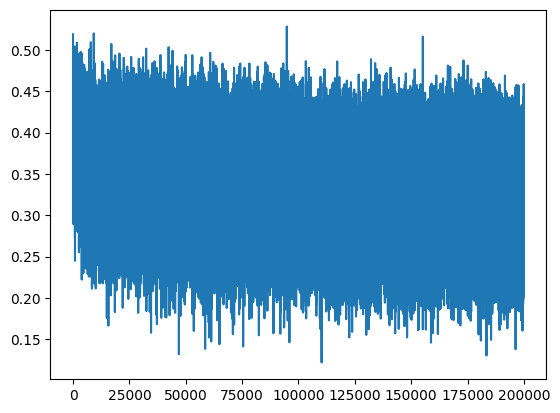

In [7]:
plt.plot(lossi)

## PyTorch API for Multi Layer Training

In [8]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean calc
            xvar = x.var(0, keepdim=True) # batch var calc
        else:
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []



## Evaluation on Dev & Test Data

In [10]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  output = x @ W1 #+ b1
  output = bngain * (output - bnmean_run) / bnstd_run + bnbias
  h = torch.tanh(output)
  fin = h @ W2 + b2
  loss = F.cross_entropy(fin, y)
  print(split, loss.item())

# put layers into eval mode
split_loss('train')
split_loss('val')

train 2.0938923358917236
val 2.12632155418396


## Use model to predict names

In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      output = x @ W1 #+ b1
      output = bngain * (output - bnmean_run) / bnstd_run + bnbias
      h = torch.tanh(output)
      fin = h @ W2 + b2
      logits = fin
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khi.
mri.
reigh.
sacarsie.
mahnen.
delynn.
jareen.
nellara.
chaiiv.
kaleigh.
ham.
jorn.
quinthanlin.
alvin.
quinathoniearynn.
jaxeenissabee.
deci.
abette.
